### 对opencv中三种跟踪算法进行比较，本次选择KCF、CSRT、MOSSE

# 一、测试视频介绍：

<p>1.fast：苏炳添9.83夺冠后程冲刺视频；特点：物体运动速度快、背景变化小、物体持续形变、冲刺重点有物体重合（遮挡）、存在相似目标
<p>2.deformation：王者荣耀花木兰单杀吕布视频；特点：物体形变大，且物体光照变化，物体有部分遮挡、颜色变化大
<p>3.face：本人人脸视频：；特点：物体移动缓慢、物体变化小，背景变化小
<p>4.background：夜店跳舞视频；特点：背景变化、光线暗且有变化、物体有形变

# 二、实验过程及代码

In [3]:
import cv2
import sys
import matplotlib.pyplot as plt
v = input('输入测试视频号是:')
video_path = f'{v}.mp4'
#从视频文件中读取视频
video = cv2.VideoCapture(video_path)
if not video.isOpened():
    print("无法打开视频文件。")
    sys.exit()
#记录每帧目标框的起点坐标和宽度、高度
bboxes = []
while True:
    success, frame = video.read()
    if not success:
        break

    # 在图像上选择目标框
    bbox = cv2.selectROI(frame, False)

    # 将边界框保存到列表中
    x,y,width,height = [int(i) for i in bbox]
    bboxes.append((x,y,width,height))

    cv2.imshow("标注", frame)
    if cv2.waitKey(1) == 27:  # 按下ESC键退出
        break

cv2.destroyAllWindows()


输入测试视频号是:c


In [4]:
print(bboxes)

[(521, 200, 241, 253), (530, 191, 213, 261), (497, 174, 286, 271), (511, 187, 251, 263), (554, 164, 201, 236), (547, 140, 247, 320), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0)]


In [5]:
# 删除空格和括号，并将每个列表元组单独一行
for bbox in bboxes:
    bbox_str = str(bbox).replace(' ', '').replace('(', '').replace(')', '')   

# 写入txt文件
    output_path = f'bbox_gt_cleaned{v}.txt'

    with open(output_path, 'a') as f:
       
            f.write( bbox_str+ '\n')
#因为是txt只能追加所以每个视频的数据集必须新建文件，否则会在上一个文化数据上追加

In [6]:
#定义计算两个边界框的交并比函数
def calculate_iou(bbox1, bbox2):
    # 提取边界框的坐标
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # 计算边界框的面积
    area1 = w1 * h1
    area2 = w2 * h2

    # 计算边界框的交集
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    intersection = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # 计算IoU
    iou = intersection / (area1 + area2 - intersection)

    return iou

def calculate_drift(bbox1, bbox2):
    # 计算边界框中心点坐标
    cx1, cy1 = bbox1[0] + bbox1[2] / 2, bbox1[1] + bbox1[3] / 2
    cx2, cy2 = bbox2[0] + bbox2[2] / 2, bbox2[1] + bbox2[3] / 2

    # 计算中心点坐标之间的距离，欧氏距离公式((cx2 - cx1) ** 2 + (cy2 - cy1) ** 2) ** 0.5
    drift = ((cx2 - cx1) ** 2 + (cy2 - cy1) ** 2) ** 0.5

    return drift

video_path = f'{v}.mp4'
cap = cv2.VideoCapture(video_path)

bbox_gt_path = f'bbox_gt_cleaned{v}.txt'
with open(bbox_gt_path, 'r',encoding='utf-8') as f:
    bbox_gt_data = f.readlines()
# 定义跟踪算法
trackers = {
    'KCF': cv2.TrackerKCF_create(),
    'CSRT': cv2.TrackerCSRT_create(),
    'MOSSE': cv2.legacy.TrackerMOSSE_create()
}

# 初始化统计变量
total_frames = len(bbox_gt_data)
accuracies = {}
processing_times = {}
drifts = {}
for algo_name, tracker in trackers.items():
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # 重置视频帧位置
    bbox_gt_idx = 0  # bbox_gt数据集索引
    bbox_prev = None  # 上一帧的边界框

    # 初始化跟踪器
    frame = cap.read()[1]
    bbox_gt = [int(coord) for coord in bbox_gt_data[0].split(',')]
    bbox = tuple(bbox_gt)
    tracker.init(frame, bbox)

    # 初始化统计变量
    iou_sum = 0
    drift_sum = 0
    processing_time_sum = 0

    # 循环遍历视频帧
    for frame_idx in range(1, total_frames):
        frame = cap.read()[1]
        bbox_gt = [int(coord) for coord in bbox_gt_data[frame_idx].split(',')]

        # 跟踪器处理
        start_time = cv2.getTickCount()
        success, bbox = tracker.update(frame)
        end_time = cv2.getTickCount()
        processing_time = (end_time - start_time) / cv2.getTickFrequency()

        if success:
            # 计算准确率（IoU）
            iou = calculate_iou(bbox, bbox_gt)
            iou_sum += iou

            # 计算跟踪漂移
            if bbox_prev is not None:
                drift = calculate_drift(bbox, bbox_prev)
                drift_sum += drift

            # 更新上一帧边界框
            bbox_prev = bbox

        # 更新统计变量
        processing_time_sum += processing_time

    # 计算平均准确率和平均跟踪漂移
    mean_iou = iou_sum / total_frames
    mean_drift = drift_sum / (total_frames - 1)
    mean_processing_time = processing_time_sum / total_frames

    # 记录结果
    accuracies[algo_name] = mean_iou
    drifts[algo_name] = mean_drift
    processing_times[algo_name] = mean_processing_time
    print(f'测试视频：{v}.mp4')
    print(f'算法: {algo_name}')
    print(f'平均准确率: {mean_iou}')
    print(f'平均跟踪漂移: {mean_drift}')
    print(f'平均处理时间: {mean_processing_time}')

# 释放视频
cap.release()

测试视频：c.mp4
算法: KCF
平均准确率: 0.22794256422224432
平均跟踪漂移: 8.945516751953315
平均处理时间: 0.06592787647058825
测试视频：c.mp4
算法: CSRT
平均准确率: 0.22553494621108083
平均跟踪漂移: 8.889903439727744
平均处理时间: 0.13204778823529412
测试视频：c.mp4
算法: MOSSE
平均准确率: 0.23086425753183182
平均跟踪漂移: 9.519618038438265
平均处理时间: 0.006623829411764707


# 三、对测试数据进行分析

### 对于fast：苏炳添9.83夺冠后程冲刺视频；特点：物体运动速度快、背景变化小、物体持续形变、冲刺重点有物体重合（遮挡）、存在相似目标

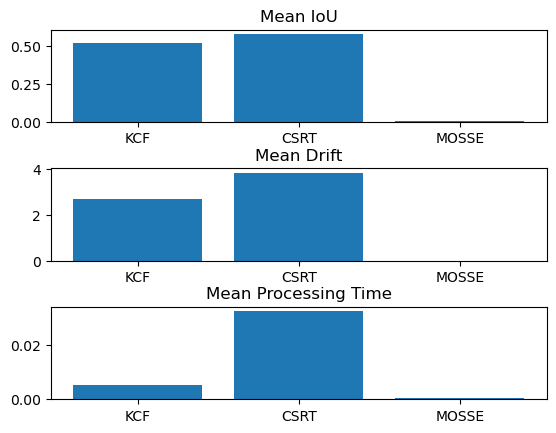

In [10]:
# 算法名称和对应的统计数据
algorithm_names = ['KCF', 'CSRT', 'MOSSE']
mean_iou_values = [0.5187299525419178,  0.5764476464394128, 0.006430868167202572]
mean_drift_values = [2.6879204070139404, 3.8444089804082027, 0.0]
mean_processing_time_values = [0.005294556666666667,  0.03243578222222222, 0.0003980044444444444]

# 创建一个Figure对象和三个子图
fig, axs = plt.subplots(3)

# 绘制平均准确率的柱状图
axs[0].bar(algorithm_names, mean_iou_values)
axs[0].set_title('Mean IoU')

# 绘制平均跟踪漂移的柱状图
axs[1].bar(algorithm_names, mean_drift_values)
axs[1].set_title('Mean Drift')

# 绘制平均处理时间的柱状图
axs[2].bar(algorithm_names, mean_processing_time_values)
axs[2].set_title('Mean Processing Time')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.5)

# 显示图形
plt.show()

<p>测试视频：fast.mp4
<p>算法: KCF
<p>平均准确率: 0.5187299525419178
<p>平均跟踪漂移: 2.6879204070139404
<p>平均处理时间: 0.005294556666666667
<p>测试视频：fast.mp4
<p>算法: CSRT
<p>平均准确率: 0.5764476464394128
<p>平均跟踪漂移: 3.8444089804082027
<p>平均处理时间: 0.03243578222222222
<p>测试视频：fast.mp4
<p>算法: MOSSE
<p>平均准确率: 0.006430868167202572
<p>平均跟踪漂移: 0.0
<p>平均处理时间: 0.0003980044444444444

##### 由上述实验数据显示，对于物体运动速度快、背景变化小、物体持续形变、冲刺重点有物体重合等特点的运动物体，KCF算法跟踪漂移最小，准确率也较高，而 MOSSE算法根本就没有捕捉到想要跟踪的物体，原因是对于短跑冲刺每个运动员在高速运动中，对于MOSSE算法视为相似物体，所以跟踪失败，但是MOSSE算法处理速度是三种算法中最快的，CSRT算法准确率最高，但速度最慢

### 对于deformation：王者荣耀花木兰单杀吕布视频；特点：物体形变大，且物体光照变化，物体有部分遮挡、颜色变化大

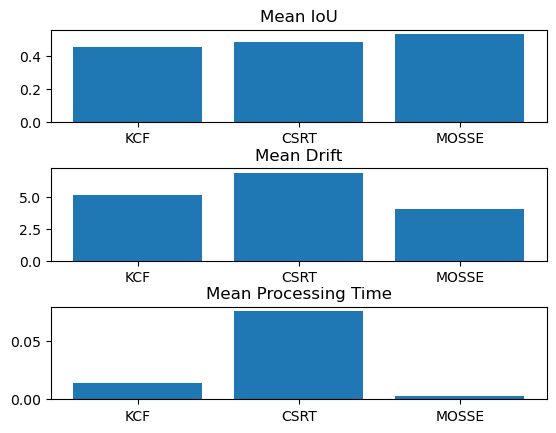

In [11]:
# 算法名称和对应的统计数据
algorithm_names = ['KCF', 'CSRT', 'MOSSE']
mean_iou_values = [0.4572715101882451, 0.4900513079676318, 0.535323975052555]
mean_drift_values = [5.158578188036686,6.895460581970102,4.081503641406115]
mean_processing_time_values = [0.014242626415094342,  0.07489726132075471,0.002713100943396226]

# 创建一个Figure对象和三个子图
fig, axs = plt.subplots(3)

# 绘制平均准确率的柱状图
axs[0].bar(algorithm_names, mean_iou_values)
axs[0].set_title('Mean IoU')

# 绘制平均跟踪漂移的柱状图
axs[1].bar(algorithm_names, mean_drift_values)
axs[1].set_title('Mean Drift')

# 绘制平均处理时间的柱状图
axs[2].bar(algorithm_names, mean_processing_time_values)
axs[2].set_title('Mean Processing Time')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.5)

# 显示图形
plt.show()

<p>测试视频：deformation.mp4
<p>算法: KCF
<p>平均准确率: 0.4572715101882451
<p>平均跟踪漂移: 5.158578188036686
<p>平均处理时间: 0.014242626415094342
<p>测试视频：deformation.mp4
<p>算法: CSRT
<p>平均准确率: 0.4900513079676318
<p>平均跟踪漂移: 6.895460581970102
<p>平均处理时间: 0.07489726132075471
<p>测试视频：deformation.mp4
<p>算法: MOSSE
<p>平均准确率: 0.535323975052555
<p>平均跟踪漂移: 4.081503641406115
<p>平均处理时间: 0.002713100943396226

##### 由上述实验数据显示，对于物体形变较大、出现遮挡，MOSSE算法的跟踪漂移最小，准确率最高，具有很好的效果，其次就是CSRT算法的效果较好，相比较而言KCF算法在对于光照变化和形变较大的目标、表现欠佳。处理速度方面最快的还是MOSSE，最慢的还是CSRT。

### 对于face：本人人脸视频：；特点：物体移动缓慢、物体变化小，背景变化小

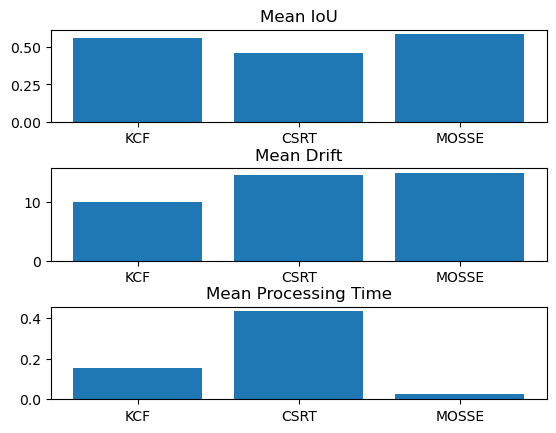

In [12]:
# 算法名称和对应的统计数据
algorithm_names = ['KCF', 'CSRT', 'MOSSE']
mean_iou_values = [0.5573870607164543, 0.45997626355303933,0.585308240327307]
mean_drift_values = [9.92312463470653,14.67867102184568,15.008022041731516]
mean_processing_time_values = [0.15329220294117646,  0.43380266274509827,0.028129876470588244]

# 创建一个Figure对象和三个子图
fig, axs = plt.subplots(3)

# 绘制平均准确率的柱状图
axs[0].bar(algorithm_names, mean_iou_values)
axs[0].set_title('Mean IoU')

# 绘制平均跟踪漂移的柱状图
axs[1].bar(algorithm_names, mean_drift_values)
axs[1].set_title('Mean Drift')

# 绘制平均处理时间的柱状图
axs[2].bar(algorithm_names, mean_processing_time_values)
axs[2].set_title('Mean Processing Time')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.5)

# 显示图形
plt.show()

<p>测试视频：face.mp4
<p>算法: KCF
<p>平均准确率: 0.5573870607164543
<p>平均跟踪漂移: 9.92312463470653
<p>平均处理时间: 0.15329220294117646
<p>测试视频：face.mp4
<p>算法: CSRT
<p>平均准确率: 0.45997626355303933
<p>平均跟踪漂移: 14.67867102184568
<p>平均处理时间: 0.43380266274509827
<p>测试视频：face.mp4
<p>算法: MOSSE
<p>平均准确率: 0.585308240327307
<p>平均跟踪漂移: 15.008022041731516
<p>平均处理时间: 0.028129876470588244

##### 由上述实验数据显示，对于物体移动缓慢、物体变化小，背景变化小，CSRT算法的表现就不如另外两种算法，其中MOSSE算法准确率竟然接近60%，可见MOSSE算法对于这种情况更为实用

### 对于background：夜店跳舞视频；特点：背景变化、光线暗且有变化、物体有形变

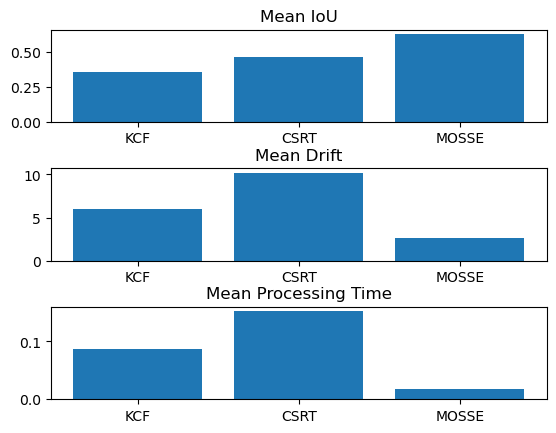

In [13]:
# 算法名称和对应的统计数据
algorithm_names = ['KCF', 'CSRT', 'MOSSE']
mean_iou_values = [0.355290786344998, 0.4619042538046963,0.6263443428414269]
mean_drift_values = [5.963523873527226,10.198565576432532,2.583502124013772]
mean_processing_time_values = [0.08740756421052634,0.15207775157894735,0.017985148421052623]

# 创建一个Figure对象和三个子图
fig, axs = plt.subplots(3)

# 绘制平均准确率的柱状图
axs[0].bar(algorithm_names, mean_iou_values)
axs[0].set_title('Mean IoU')

# 绘制平均跟踪漂移的柱状图
axs[1].bar(algorithm_names, mean_drift_values)
axs[1].set_title('Mean Drift')

# 绘制平均处理时间的柱状图
axs[2].bar(algorithm_names, mean_processing_time_values)
axs[2].set_title('Mean Processing Time')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.5)

# 显示图形
plt.show()

<p>测试视频：background.mp4
<p>算法: KCF
<p>平均准确率: 0.355290786344998
<p>平均跟踪漂移: 5.963523873527226
<p>平均处理时间: 0.08740756421052634
<p>测试视频：background.mp4
<p>算法: CSRT
<p>平均准确率: 0.4619042538046963
<p>平均跟踪漂移: 10.198565576432532
<p>平均处理时间: 0.15207775157894735
<p>测试视频：background.mp4
<p>算法: MOSSE
<p>平均准确率: 0.6263443428414269
<p>平均跟踪漂移: 2.583502124013772
<p>平均处理时间: 0.017985148421052623

##### 上述验数据显示，对于背景变化、光线暗且有变化、物体有形变，MOSSE算法准确率远高于其他两种算法，跟踪漂移也是最小的，处理速度也是最快，相比较而言CSRT算法准确率较好，KCF是处理效果是最差的；处理速度最快的还是MOSSE，最慢的还是CSRT。

# 四、结论

综合来看，<p>KCF算法在尺度变化小和部分遮挡、物体运动速度快情况下具有较好的效果，但对于光照变化和形变较大的目标表现欠佳；适用场景：追踪速度要求较高、目标有较小形变和光照变化的场景，如运动物体追踪<p>
       <p>CSRT算法对于光照变化和一定程度的目标形变有较好的效果，但在处理目标尺度变化和完全遮挡方面相对薄弱，并且处理速度相对与另外两种算法速度慢；适用场景：一定程度形变和遮挡的目标跟踪，如车辆追踪、行人检测<p>
       <p>MOSSE算法计算速度非常快，对于光照变化和部分遮挡等问题具有较好的效果，但在存在相似目标的情况下，可能会出现错误跟踪；适用场景：目标形变和光照变化较小的场景，如手势识别<p>

# 五、误差以及偶然性

由于测试视频的特点和数据量小，还有每个视频帧中手动标注都会产生误差，所以算法中的优点以及缺点都有一些没有体现出来，也存在一定的偶然性，但是在大量数据和时间下相信会对比的更好